# Выбор локации для скважины

Допустим, что мы работаем в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Нужно постройить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Описание данных

id — уникальный идентификатор скважины;

f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);

product — объём запасов в скважине (тыс. баррелей).

Условия задачи:

Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).

При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.

Бюджет на разработку скважин в регионе — 10 млрд рублей.

При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

## Загрузка и подготовка данных

Импортируем необходимые для работы библиотеки и метрики.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from scipy import stats as st
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.preprocessing import OrdinalEncoder 

Загружаем данные.

In [2]:
try:
    data_0 = pd.read_csv('/datasets/geo_data_0.csv')
    data_1 = pd.read_csv('/datasets/geo_data_1.csv')
    data_2 = pd.read_csv('/datasets/geo_data_2.csv')
except:
    0

Ознакомимся с данными геологоразведки в 1 регионе.

In [3]:
data_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [4]:
data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [5]:
data_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [6]:
data_0.corr()

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


Ознакомимся с данными геологоразведки во 2 регионе.

In [7]:
data_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [8]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [9]:
data_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [10]:
data_1.corr()

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


Ознакомимся с данными геологоразведки в 3 регионе.

In [11]:
data_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [12]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [13]:
data_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


In [14]:
data_2.corr()

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


Построим гистаграмму распределения запасов сырья по регионам. 

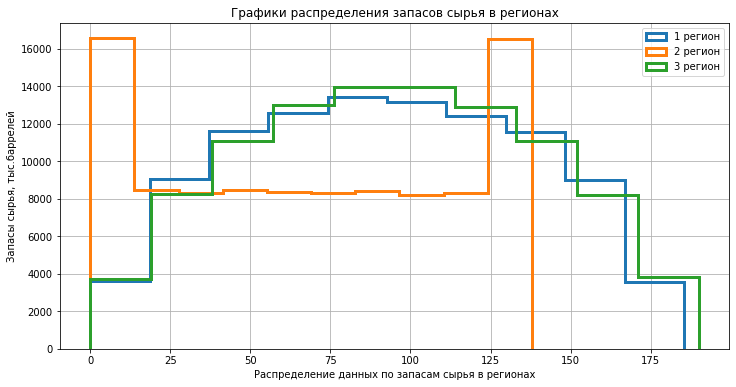

In [15]:
plt.title('Графики распределения запасов сырья в регионах')

data_0['product'].plot(kind='hist',figsize=(12,6),grid=True, legend=True, histtype='step', linewidth=3, label='1 регион')
data_1['product'].plot(kind='hist',figsize=(12,6),grid=True, legend=True, histtype='step', linewidth=3, label='2 регион')
data_2['product'].plot(kind='hist',figsize=(12,6),grid=True, legend=True, histtype='step', linewidth=3, label='3 регион')

plt.xlabel('Распределение данных по запасам сырья в регионах')
plt.ylabel('Запасы сырья, тыс.баррелей')
plt.show()

Мы успешно загрузили данные, импортировали необходимые библиотеки и метрики. 
Посмотрев информацию о данных, мы отметили, что пропусков не содержится и предобработка не требуется. 

На гистограмме можем увидеть, что в 1 и 3 регионах запасы сырья получили нормальное распределение, у 2 региона график значительно отличается от нормального распределения, выбиваются самые низкие и самые высокие значения. 

Также отметим высокую корелляцию (более 0,999) показателя запасов во 2 втором регионе от признака f2, что может оказать влияние на предсказания модели.

## Обучение и проверка модели

Подготовим обучающую и валидационную выборки в соотношениии 75/25. Удалим столбец с индентификатором как неинформативный.

In [16]:
target_0=data_0['product']
features_0=data_0.drop(['product', 'id'], axis=1)

target_1=data_1['product']
features_1=data_1.drop(['product', 'id'], axis=1)

target_2=data_2['product']
features_2=data_2.drop(['product', 'id'], axis=1)

Разделим данные на выборки и проверим их размерность.

In [17]:
features_train_0, features_valid_0, target_train_0, target_valid_0 = train_test_split(features_0, target_0, test_size=0.25, random_state=12345)
tv_shape=target_valid_0.shape[0]/target_0.shape[0]
tt_shape=target_train_0.shape[0]/target_0.shape[0]

print('Размер обучающей выборки- {:.0%}'.format(tt_shape))
print('Размер валидационной выборки - {:.0%}'.format(tv_shape))

Размер обучающей выборки- 75%
Размер валидационной выборки - 25%


In [18]:
features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(features_1, target_1, test_size=0.25, random_state=12345)
tv_shape=target_valid_1.shape[0]/target_1.shape[0]
tt_shape=target_train_1.shape[0]/target_2.shape[0]

print('Размер обучающей выборки- {:.0%}'.format(tt_shape))
print('Размер валидационной выборки - {:.0%}'.format(tv_shape))

Размер обучающей выборки- 75%
Размер валидационной выборки - 25%


In [19]:
features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(features_2, target_2, test_size=0.25, random_state=12345)
tv_shape=target_valid_2.shape[0]/target_2.shape[0]
tt_shape=target_train_2.shape[0]/target_2.shape[0]

print('Размер обучающей выборки- {:.0%}'.format(tt_shape))
print('Размер валидационной выборки - {:.0%}'.format(tv_shape))

Размер обучающей выборки- 75%
Размер валидационной выборки - 25%


Обучим модель Линейной регрессии отдельно для каждого региона.


In [20]:
model_0=LinearRegression()
model_0.fit(features_train_0, target_train_0)
predict_0=model_0.predict(features_valid_0)
rmse_0 = mean_squared_error(target_valid_0, predict_0)**0.5
print('Среднеквадратичная ошибка RMSE: %.2f'% rmse_0)
print('Коэффициент детерминации: %.2f' % r2_score(target_valid_0, predict_0))

Среднеквадратичная ошибка RMSE: 37.58
Коэффициент детерминации: 0.28


In [21]:
model_1=LinearRegression()
model_1.fit(features_train_1, target_train_1)
predict_1=model_1.predict(features_valid_1)
rmse_1=mean_squared_error(target_valid_1, predict_1)**0.5
print('Среднеквадратичная ошибка RMSE: %.2f' % rmse_1)
print('Коэффициент детерминации: %.2f' % r2_score(target_valid_1, predict_1))

Среднеквадратичная ошибка RMSE: 0.89
Коэффициент детерминации: 1.00


In [22]:
model_2=LinearRegression()
model_2.fit(features_train_2, target_train_2)
predict_2=model_2.predict(features_valid_2)
rmse_2 = mean_squared_error(target_valid_2, predict_2)**0.5
print('Среднеквадратичная ошибка RMSE: %.2f'% rmse_2)
print('Коэффициент детерминации: %.2f' % r2_score(target_valid_2, predict_2))

Среднеквадратичная ошибка RMSE: 40.03
Коэффициент детерминации: 0.21


In [23]:
comparison_tabl = pd.DataFrame(index=['средний запас предсказанного сырья','RMSE модели'], columns=['1 регион','2 регион','3 регион'])
comparison_tabl['1 регион'] = predict_0.mean(), rmse_0
comparison_tabl['2 регион'] = predict_1.mean(), rmse_1
comparison_tabl['3 регион'] = predict_2.mean(), rmse_2
comparison_tabl

,1 регион,2 регион,3 регион
средний запас предсказанного сырья,92.592568,68.728547,94.965046
RMSE модели,37.579422,0.893099,40.029709


В получившейся таблице средних значений предсказаний объемов сырья и RMSE каждой модели, значения для 2 региона заметно отличаются от других, вероятно, это связано с высокой зависимости целевого признака от вышеупомянутого 'f2'.

## Подготовка к расчёту прибыли

При разведке региона исследуем 500 точек, из которых с помощью машинного обучения выберем 200 лучших для разработки.
Бюджет на разработку скважин в регионе — 10 млрд рублей.
При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс.
рублей, поскольку объём указан в тысячах баррелей.
После оценки рисков оставим лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выберем регион с наибольшей средней прибылью.

In [24]:
budget = 10000000 #Бюджет на разработку скважин в регионе, тыс.руб
income_one_product = 450 #Доход с каждой единицы продукта, тыс.руб
target_probability_losses = 2.5/100 # вероятность убытков
product_mean_0 = data_0['product'].mean()
product_mean_1 = data_1['product'].mean()
product_mean_2 = data_2['product'].mean()

In [25]:
print('Cредний запас сырья в 1 регионе = %.2f млн.баррелей'%product_mean_0)
print('Cредний запас сырья в 2 регионе = %.2f млн.баррелей'%product_mean_1)
print('Cредний запас сырья в 3 регионе = %.2f млн.баррелей'%product_mean_2)

Cредний запас сырья в 1 регионе = 92.50 млн.баррелей
Cредний запас сырья в 2 регионе = 68.83 млн.баррелей
Cредний запас сырья в 3 регионе = 95.00 млн.баррелей


In [26]:
budg_per_1_point=(budget/200)# тыс.руб
print('Бюджет на разработку одной скважины = ', budg_per_1_point/1000,'млн.руб')

Бюджет на разработку одной скважины =  50.0 млн.руб


In [27]:
v_product = budg_per_1_point/income_one_product
print('Объём сырья для безубыточной разработки >= %.2f'%v_product,'тыс.баррелей')

Объём сырья для безубыточной разработки >= 111.11 тыс.баррелей


Сраним полученное значение с количеством запасов сырья в регионах.

In [28]:
data_0['profit']=(data_0['product']*(income_one_product)).round(2) # profit, тыс.руб
data_0.head()

,id,f0,f1,f2,product,profit
0,txEyH,0.705745,-0.497823,1.221170,105.280062,47376.03
1,2acmU,1.334711,-0.340164,4.365080,73.037750,32866.99
2,409Wp,1.022732,0.151990,1.419926,85.265647,38369.54
3,iJLyR,-0.032172,0.139033,2.978566,168.620776,75879.35
4,Xdl7t,1.988431,0.155413,4.751769,154.036647,69316.49


In [29]:
data_0['roi']=((data_0['profit']-budg_per_1_point)/budg_per_1_point*100).round(2)
data_0.head()

,id,f0,f1,f2,product,profit,roi
0,txEyH,0.705745,-0.497823,1.221170,105.280062,47376.03,-5.25
1,2acmU,1.334711,-0.340164,4.365080,73.037750,32866.99,-34.27
2,409Wp,1.022732,0.151990,1.419926,85.265647,38369.54,-23.26
3,iJLyR,-0.032172,0.139033,2.978566,168.620776,75879.35,51.76
4,Xdl7t,1.988431,0.155413,4.751769,154.036647,69316.49,38.63


In [30]:
print('Разница объёма сырья для безубыточной разработки скважины относительно среднего значения по 1 региону составляет: {:.2%}'.format(product_mean_0/v_product-1))
print('({:.2f} тыс.баррелей)'.format(v_product-product_mean_0))

Разница объёма сырья для безубыточной разработки скважины относительно среднего значения по 1 региону составляет: -16.75%
(18.61 тыс.баррелей)


In [31]:
data_1['profit']=(data_1['product']*(income_one_product)).round(2) # profit, тыс.руб
data_1.head()

,id,f0,f1,f2,product,profit
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103,1430.60
1,62mP7,14.272088,-3.475083,0.999183,26.953261,12128.97
2,vyE1P,6.263187,-5.948386,5.001160,134.766305,60644.84
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408,62075.43
4,AHL4O,12.702195,-8.147433,5.004363,134.766305,60644.84


In [32]:
data_1['roi']=((data_1['profit']-budg_per_1_point)/budg_per_1_point*100).round(2)
data_1.head()

,id,f0,f1,f2,product,profit,roi
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103,1430.60,-97.14
1,62mP7,14.272088,-3.475083,0.999183,26.953261,12128.97,-75.74
2,vyE1P,6.263187,-5.948386,5.001160,134.766305,60644.84,21.29
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408,62075.43,24.15
4,AHL4O,12.702195,-8.147433,5.004363,134.766305,60644.84,21.29


In [33]:
print('Разница объёма сырья для безубыточной разработки скважины относительно среднего значения по 1 региону составляет: {:.2%}'.format(product_mean_1/v_product-1))
print('({:.2f} тыс.баррелей)'.format(v_product-product_mean_1))

Разница объёма сырья для безубыточной разработки скважины относительно среднего значения по 1 региону составляет: -38.06%
(42.29 тыс.баррелей)


In [34]:
data_2['profit']=(data_2['product']*(income_one_product)).round(2) # profit, тыс.руб
data_2.head()

,id,f0,f1,f2,product,profit
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673,12491.40
1,WJtFt,0.262778,0.269839,-2.530187,56.069697,25231.36
2,ovLUW,0.194587,0.289035,-5.586433,62.871910,28292.36
3,q6cA6,2.236060,-0.553760,0.930038,114.572842,51557.78
4,WPMUX,-0.515993,1.716266,5.899011,149.600746,67320.34


In [35]:
data_2['roi']=((data_2['profit']-budg_per_1_point)/budg_per_1_point*100).round(2)
data_2.head()

,id,f0,f1,f2,product,profit,roi
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673,12491.40,-75.02
1,WJtFt,0.262778,0.269839,-2.530187,56.069697,25231.36,-49.54
2,ovLUW,0.194587,0.289035,-5.586433,62.871910,28292.36,-43.42
3,q6cA6,2.236060,-0.553760,0.930038,114.572842,51557.78,3.12
4,WPMUX,-0.515993,1.716266,5.899011,149.600746,67320.34,34.64


In [36]:
print('Разница объёма сырья для безубыточной разработки скважины относительно среднего значения по 1 региону составляет: {:.2%}'.format(product_mean_2/v_product-1))
print('({:.2f} тыс.баррелей)'.format(v_product-product_mean_2))

Разница объёма сырья для безубыточной разработки скважины относительно среднего значения по 1 региону составляет: -14.50%
(16.11 тыс.баррелей)


Согласно полученным данным среднего количество запасов сырья по регионам недостаточно для окупаемости разработки, соответственно нужно выбрать скважины с наибольшим объемом запасов.

## Расчёт прибыли и рисков 

Отсортируем предсказания по 1 региону и возьмем 200 наибольших значений.

In [37]:
probs_sorted_0 = pd.Series(predict_0, index=target_valid_0.index).sort_values(ascending=False)
selected_max_0 = probs_sorted_0[:200]
selected_max_0

93073    180.180713
46784    176.252213
78948    175.850623
43388    175.658429
6496     173.299686
            ...    
30488    148.507064
98799    148.481767
53840    148.476498
4638     148.436761
75908    148.365941
Length: 200, dtype: float64

Найдем объем лучших 200 скважин, выбранных для разработки.

In [38]:
selected_max_0_sum = selected_max_0.sum()
print('Объем запасов сырья в 200 лучших скважинах = %.2f тыс.баррелей' %selected_max_0_sum)
profit_pred_0=(selected_max_0_sum*income_one_product) - budget
print('Прибыль для полученного объёма сырья = %.2f тыс.рублей' %profit_pred_0)

Объем запасов сырья в 200 лучших скважинах = 31102.33 тыс.баррелей
Прибыль для полученного объёма сырья = 3996048.88 тыс.рублей


Создадим функцию для подсчета объема запасов сырья в выбранных скважинах и предполагаемой выручки.

In [62]:
def profit_for_vp(predict, target, count, print_var=1):
    probs_sorted = pd.Series(predict, index=target.index).sort_values(ascending=False)
    selected_max = probs_sorted[:count].sum()
    profit_pred=(selected_max*income_one_product) - budget
    print('Суммарный запас сырья в 200 лучших скважинах составит: %.2f тыс.баррелей' %selected_max)
    print('Прибыль для полученного объёма сырья составит %.2f млн.рублей' %(profit_pred/1000))


Применим полученную функцию для трех регионов.

In [63]:
print('Регион 1')
profit_for_vp (predict_0, target_valid_0, 200)

Регион 1
Суммарный запас сырья в 200 лучших скважинах составит: 31102.33 тыс.баррелей
Прибыль для полученного объёма сырья составит 3996.05 млн.рублей


In [64]:
print('Регион 2')
profit_for_vp(predict_1, target_valid_1, 200)

Регион 2
Суммарный запас сырья в 200 лучших скважинах составит: 27746.03 тыс.баррелей
Прибыль для полученного объёма сырья составит 2485.71 млн.рублей


In [65]:
print('Регион 3')
profit_for_vp(predict_2, target_valid_2, 200)

Регион 3
Суммарный запас сырья в 200 лучших скважинах составит: 29603.90 тыс.баррелей
Прибыль для полученного объёма сырья составит 3321.75 млн.рублей


Все 3 региона поценциально прибыльные, лучшие показатели у Региона 1.

## Bootstrap 

Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли

Найдём среднюю прибыль, 95%-й доверительный интервал и риск убытков.

Прибыль:
- положительная разница между суммарными доходами (выручка от реализации товаров и услуг) и затратами на разработку скважин

Убыток:
- уменьшение материальных и денежных ресурсов в результате превышения расходов над доходами (отрицательная прибыль)

In [66]:
def profit_for_vp2 (predict, target, count):
    probs_sorted = pd.Series(predict).sort_values(ascending=False)
    selected_points = target[probs_sorted.index][:count]
    product = selected_points.sum()
    revenue = product * income_one_product
    return revenue - budget

In [67]:
def bootstap_1000(target, predict):
    values = []
    count=0
    state = np.random.RandomState(12345)
    predict_e = pd.Series(predict, index=target.index)
    
    for i in range(1000):
        target_subsample = target.sample(n=500, replace=True, random_state=state)
  
        probs_subsample = predict_e[target_subsample.index]
        values.append(profit_for_vp2(probs_subsample, target_subsample, 200))  
    ##for i in values:
        #if i < 0:
            #count +=1
            
    values = pd.Series(values)
    mean = values.mean()
    confidence_interval = st.t.interval(0.95, len(values)-1, values.mean(), values.sem())
    
    plt.title('Распределение прибыли')
    values.plot(kind="hist", grid=True, figsize=(8,5))
    plt.xlabel('Прибыль, тыс.руб')
    plt.ylabel('Количество')
    plt.show()
    
    low_95 = values.quantile(0.025)
    high_95 = values.quantile(0.975)
    
    print("Средняя прибыль: {:.2f} млн.руб".format(mean/1000))
    print('С вероятностью 95% прибыль в данном регионе будет составлять от: {:.2f} млн.руб до: {:.2f} млн.руб'.format((low_95/1000),(high_95/1000)))
    print("95%-ый доверительный интервал: от {:.2f} млн.руб до {:.2f} млн.руб". format((confidence_interval[0]/1000),(confidence_interval[1]/1000)))
    print ('Процент вероятности убытка в данном регионе составит {:.1%}'.format((values < 0).mean() * 100))

Распределение прибыли в 1 регионе.

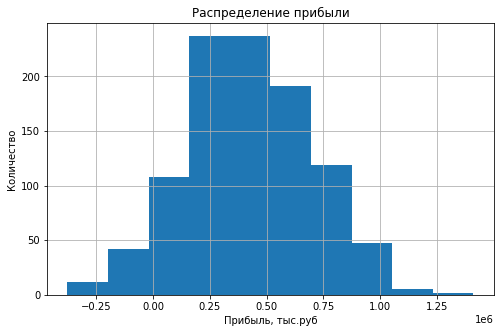

Средняя прибыль: 425.94 млн.руб
С вероятностью 95% прибыль в данном регионе будет составлять от: -102.09 млн.руб до: 947.98 млн.руб
95%-ый доверительный интервал: от 408.73 млн.руб до 443.14 млн.руб
Процент вероятности убытка в данном регионе составит 600.0%


In [68]:
bootstap_1000(target_valid_0,predict_0)

Распределение прибыли во 2 регионе.

In [ ]:
bootstap_1000(target_valid_1,predict_1)

Распределение прибыли в 3 регионе.

In [ ]:
bootstap_1000(target_valid_2,predict_2)

Соберем полученные данные в таблицу.

In [ ]:
comparison_tabl = pd.DataFrame(index=['Средняя прибыль в регионе, млн.руб','Суммарный запас сырья, тыс.баррелей','Вероятность убытка, %'], columns=['1 регион','2 регион','3 регион'])
comparison_tabl['1 регион'] = '425.94', '31102.05','6.0'
comparison_tabl['2 регион'] = '515.22', '27745.96','1.0'
comparison_tabl['3 регион'] = '435.01', '29603.73','6.4'
comparison_tabl


По полученному распределению среднего значения прибыли с региона, ниболее прибыльным представляется 2 регион, средняя прибыль в этом регионе составит 515.23 млн.рублей. 1 и 3 регионы демонстрируют также более высокую вероятность убытка, выше пороговой в 2,5%. 


## Выводы

Исследовав данные по запасам сырья в скважинах 3-х регионов мы обнаружили, что средний запас ресурсов по регионам недостаточен  для окупаемости вложений на разработку.

Обучив модель Линейной регрессии и применив функцию bootstrap_1000 мы выполнили предсказания значений прибыли по регионам на основе 1000 выборок.

Мы определили доверительный интервал получения прибыли в 95%, ограничив вероятность убытка значением 2,5%. Нашли наиболее перспективный регион для разработки 200 лучших скважин.

По итогу, несмотря на относительно меньшие показатели запасов сырья в 27745.96 тыс.баррелей, вероятностью убыточности в 1.0%, наибольшая прибыль в 515.23 млн.рублей ожидается при разработки 200 скважин во 2 регионе.